# 1. Import các thư viện hỗ trợ lập trình

In [1]:
from surprise import SVD, Dataset, Reader, SVDpp, NMF, NormalPredictor, KNNBasic, KNNWithMeans
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from collections import defaultdict
from surprise import accuracy
from surprise import dump
import numpy as np
import pandas as pd
import csv

# 2. Load data and EDA

In [2]:
origin_data = pd.read_csv('../Data/final_rating_not_spare.csv', usecols=['customer_id', 'product_id', 'stars'])

In [3]:
origin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20849 entries, 0 to 20848
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   product_id   20849 non-null  int64
 1   customer_id  20849 non-null  int64
 2   stars        20849 non-null  int64
dtypes: int64(3)
memory usage: 488.8 KB


In [4]:
origin_data.head()

,product_id,customer_id,stars
0,9672,53270,5
1,9672,91213,4
2,3038,56289,5
3,3038,88524,5
4,3038,72126,5


### ! Surprise library format data theo các cột: User, Item, Rating. Do đó, sử dụng file format

In [5]:
all_rating = pd.read_csv('../Data/all_rating.csv')

In [6]:
format_data = pd.read_csv('../Data/final_rating_not_spare_format.csv')
format_data.head()

,item,user,rating
0,9672,53270,5
1,9672,91213,4
2,3038,56289,5
3,3038,88524,5
4,3038,72126,5


### EDA phân bố đánh giá

In [7]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = format_data['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / format_data.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Biểu đồ phân phối của {} ratings'.format(format_data.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Số lượng'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [8]:
data = format_data.groupby('item')['rating'].count().clip(upper=40)
# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 10,
                                  end = 200,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Biểu đồ phân phối số sao đánh giá mỗi sản phẩm (Xét tối đa là 200 đánh giá)',
                   xaxis = dict(title = 'Số lượt đánh giá'),
                   yaxis = dict(title = 'Số lượng sách'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [9]:
format_data.groupby('item')['rating'].count().reset_index().sort_values('rating', ascending=False)[10:]

,item,rating
4761,9161,26
5053,9781,26
734,1420,25
4365,8370,25
4906,9455,25
...,...,...
1347,2539,1
745,1439,1
3941,7610,1
1343,2535,1


In [10]:
data = format_data.groupby('user')['rating'].count().clip(upper=40)
# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Phân phối đánh giá theo người dùng (xét tối đa 40 đánh giá)',
                   xaxis = dict(title = 'Số lượt đánh giá của mỗi người'),
                   yaxis = dict(title = 'Số lượng người dùng'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [11]:
format_data.groupby('user')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,user,rating
514,48036,148
684,63996,84
416,36454,68
499,45589,65
1335,127590,62
981,90422,61
1054,98864,58
251,19931,57
394,33591,56
356,30255,55


# 3. Surprise - model selection

In [12]:
file_path = '../Data/final_rating_not_spare_format.csv'
reader = Reader(line_format='item user rating', sep=',', rating_scale = (1,5), skip_lines=1)

data = Dataset.load_from_file(file_path, reader=reader)

In [13]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [14]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.579982,0.337362,1.879623,0.137964
KNNBasic,0.748736,0.407632,0.160083,0.231726
NormalPredictor,0.832434,0.543060,0.056975,0.137402
NMF,0.854386,0.650960,2.902573,0.103051


## Training and Testing

In [15]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=43)
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  1382 

Number of items:  4881 



In [16]:
# we are using the trainsetfull to save distance metrics
trainsetfull = data.build_full_trainset()
print('Number of users: ', trainsetfull.n_users, '\n')
print('Number of items: ', trainsetfull.n_items, '\n')

Number of users:  1382 

Number of items:  5289 



In [17]:
sim_msd = {'name':'MSD', 'user_based':True}
sim_cos = {'name':'cosine', 'user_based': False}
sim_pearson = {'name':'pearson', 'user_based': False}
sim_pearson_baseline = {'name': 'pearson_baseline','user_based':True, 'shrinkage': 100}

sim_options = [sim_msd, sim_cos, sim_pearson, sim_pearson_baseline]

In [18]:
list_of_ks = [10,20,40]

In [19]:
model = KNNBasic(sim_options = sim_options[1], verbose = False)
# model.fit(trainset)

In [20]:
cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6185  0.6050  0.6419  0.6524  0.6386  0.6313  0.0171  
MAE (testset)     0.3114  0.3106  0.3196  0.3308  0.3217  0.3189  0.0074  
Fit time          3.63    4.98    2.83    2.08    2.43    3.19    1.03    
Test time         0.31    0.27    0.20    0.27    0.23    0.26    0.04    


{'test_rmse': array([0.61853752, 0.60504219, 0.64189553, 0.65235113, 0.63857426]),
 'test_mae': array([0.31144787, 0.31064757, 0.3196143 , 0.33083038, 0.32172477]),
 'fit_time': (3.629791259765625,
  4.980447053909302,
  2.832137107849121,
  2.0842785835266113,
  2.4296114444732666),
 'test_time': (0.30900096893310547,
  0.272907018661499,
  0.20400094985961914,
  0.27199840545654297,
  0.23099970817565918)}

In [21]:
predictions = model.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.6019


0.6019153942064169

In [22]:
#Calculate TP,FP,TN,FN at every threshold level (0.0 - 5.0)

final = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0
  fn=0
  fp=0
  tn=0
  temp = []

  for uid, _, true_r, est, _ in predictions:
    if(true_r>=threshold):
      if(est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(est>=threshold):
        fp = fp+1
      else:
        tn = tn+1   

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)  

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,4170,0,0,0,1.000000,1.000000,1.000000
1,0.5,4170,0,0,0,1.000000,1.000000,1.000000
2,1.0,4170,0,0,0,1.000000,1.000000,1.000000
3,1.5,4131,23,10,6,0.994463,0.998550,0.996502
4,2.0,4131,23,10,6,0.994463,0.998550,0.996502
5,2.5,4091,60,11,8,0.985546,0.998048,0.991758
6,3.0,4087,58,13,12,0.986007,0.997072,0.991509
7,3.5,3923,168,34,45,0.958934,0.988659,0.973570
8,4.0,3903,162,40,65,0.960148,0.983619,0.971742
9,4.5,3300,516,207,147,0.864780,0.957354,0.908715


In [23]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls

In [24]:
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=4)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    f1 = (2*prec*rec)/(prec+rec)
    results.append({'K': i, 'Precision': prec, 'Recall': rec, 'F1': f1})
    

results

[{'K': 2,
  'Precision': 0.9576923076923077,
  'Recall': 0.710692611691283,
  'F1': 0.8159086544632215},
 {'K': 3,
  'Precision': 0.9561538461538456,
  'Recall': 0.8513957551437663,
  'F1': 0.900739128038716},
 {'K': 4,
  'Precision': 0.9556410256410254,
  'Recall': 0.9188937703911174,
  'F1': 0.9369072124459609},
 {'K': 5,
  'Precision': 0.9559487179487174,
  'Recall': 0.9486695634162478,
  'F1': 0.9522952307848337},
 {'K': 6,
  'Precision': 0.9556153846153842,
  'Recall': 0.9619581769541982,
  'F1': 0.9587762907010052},
 {'K': 7,
  'Precision': 0.955285714285714,
  'Recall': 0.9684711494665077,
  'F1': 0.9618332453704295},
 {'K': 8,
  'Precision': 0.9553681318681316,
  'Recall': 0.9719850377297329,
  'F1': 0.9636049524783049},
 {'K': 9,
  'Precision': 0.9553467643467642,
  'Recall': 0.97405661830065,
  'F1': 0.9646109745150491},
 {'K': 10,
  'Precision': 0.9550732600732597,
  'Recall': 0.9750161165094853,
  'F1': 0.9649416574349621}]

In [25]:
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=4.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    f1 = (2*prec*rec)/(prec+rec)
    results.append({'K': i, 'Precision': prec, 'Recall': rec, 'F1': f1})
    

results

[{'K': 2,
  'Precision': 0.8465384615384616,
  'Recall': 0.7096462305126258,
  'F1': 0.7720713759533694},
 {'K': 3,
  'Precision': 0.8443589743589737,
  'Recall': 0.8365167559610882,
  'F1': 0.8404195710088659},
 {'K': 4,
  'Precision': 0.8404487179487176,
  'Recall': 0.8939837405060069,
  'F1': 0.8663900227566985},
 {'K': 5,
  'Precision': 0.8409871794871787,
  'Recall': 0.9200905296907319,
  'F1': 0.8787622890288964},
 {'K': 6,
  'Precision': 0.8410641025641021,
  'Recall': 0.9321985398766772,
  'F1': 0.884289455592169},
 {'K': 7,
  'Precision': 0.8408260073260067,
  'Recall': 0.9373080763141488,
  'F1': 0.8864494693541207},
 {'K': 8,
  'Precision': 0.8407573260073254,
  'Recall': 0.940340736636283,
  'F1': 0.8877651150735948},
 {'K': 9,
  'Precision': 0.8408641636141629,
  'Recall': 0.9423397724632541,
  'F1': 0.8887146653071025},
 {'K': 10,
  'Precision': 0.840735958485958,
  'Recall': 0.943347022298439,
  'F1': 0.8890906662068515}]

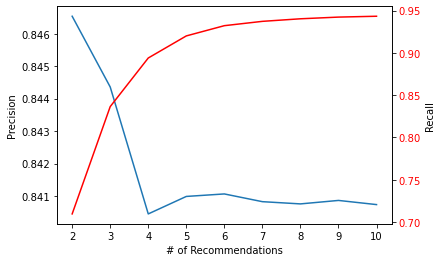

In [26]:
Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')

## Recommend and save to database

In [27]:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = model.test(testset)

In [30]:
def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n

In [31]:
all_pred = get_all_predictions(predictions)

In [32]:
#To get top 10 recommendation
n = 10

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]


In [33]:
tmp = pd.DataFrame.from_dict(all_pred)
tmp_transpose = tmp.transpose()

In [34]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results

In [35]:
all_customer = format_data['user'].unique()

In [36]:
items = pd.read_csv('../Data/final_all_clean_books.csv')

In [43]:
data = []
count = 0
for id in list(all_customer):
    results = get_predictions(str(id))
    recommended_movie_ids=[]
    for x in range(0, 10):
        rs_id = items.loc[items['new_id']==int(results[x][0])]['id'].values[0]
        recommended_movie_ids.append(rs_id)
    data.append([id, recommended_movie_ids])
data[0]

[53270,
 [540001,
  50277609,
  19276003,
  603295,
  11276962,
  2213325,
  427722,
  13828940,
  38143336,
  31954825]]

In [44]:
df = pd.DataFrame(data)

In [46]:
df.to_csv('../Data/knn-rs.csv', index=False)

In [40]:
items.loc[items['id'].isin(data[0][1])]['name'].values

array(['Combo Cô Bé Mác-Tin (10 Cuốn)',
       'Văn Học Kinh Điển Thế Giới - Phù Thủy Xứ OZ',
       'Bách Khoa Toàn Thư Cho Bé - Rèn Luyện Ý Thức',
       'Những Cuộc Phiêu Lưu Của Tom Sawyer (Truyện Tranh)',
       'Di Truyền Học: Minh Họa Sinh Động Bằng Tranh - Dẫn Nhập Ngắn Về Khoa Học',
       '10 Vạn Câu Hỏi Vì Sao? - Con Người (Tái Bản)',
       'Combo Chuyện Con Mèo Dạy Hải Âu Bay, Chuyện Con Ốc Sên Muốn Biết Tại Sao Nó Chậm Chạp, Chuyện Con Mèo Và Con Chuột Bạn Thân Của Nó, Chuyện Con Chó Tên Là Trung Thành ( Tặng Kèm Sổ Tay )',
       'Thần Thoại Ai Cập (Tái Bản 2018)',
       'Vietmath - Cùng Con Giỏi Tư Duy Toán Học Tập 1',
       'Set Ehon Âm Thanh'], dtype=object)